## Preparation

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data_dir = 'D:\DATASETS\For-Thesis\Labels'

In [3]:
def sample_count(data_dir):
    for dir in os.listdir(data_dir):
        print("{}: {}".format(dir, len(os.listdir(os.path.join(data_dir,dir)))))

In [4]:
sample_count(data_dir)

Building: 600
Plant: 600
Road: 600
Vehicle: 600


## Prepare Dataset

In [5]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [6]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0
y_one_hot = tf.keras.utils.to_categorical(y_label_idx)

In [7]:
y_one_hot[0]

array([1., 0., 0., 0.], dtype=float32)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_one_hot))
dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=1).batch(8)

In [9]:
dataset_iter = dataset.as_numpy_iterator()

In [10]:
batch = dataset_iter.next()

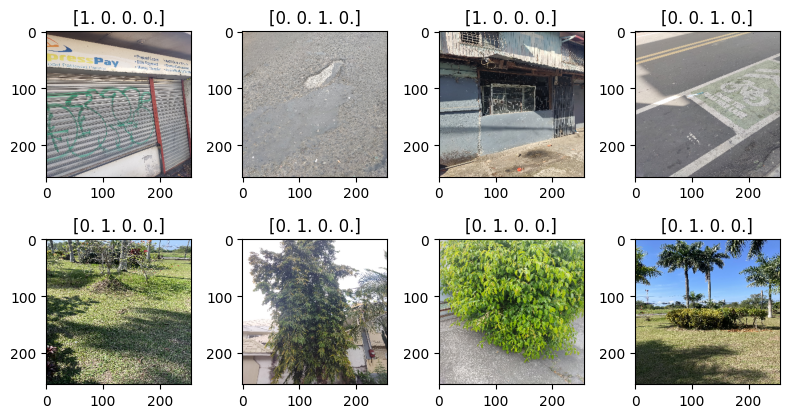

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8,4.5))
for idx, ax_idx in enumerate(itertools.product(range(2),range(4))):
    ax[ax_idx].imshow(batch[0][idx].astype(float))
    ax[ax_idx].title.set_text(batch[1][idx])
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

In [12]:
total_batch_count = len(dataset) 
train_batch_count = total_batch_count // 4 * 3  # 75% of batches
test_batch_count = total_batch_count - train_batch_count
print(total_batch_count , train_batch_count, test_batch_count)

300 225 75


In [13]:
train_size, test_size = train_batch_count, test_batch_count
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size).take(test_size)

In [14]:
train_set, val_set = tf.keras.utils.split_dataset(dataset=train_set, left_size=0.75, shuffle=True, seed=1)

## Make Model

In [19]:
model = Sequential()
model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
model.add(RandomRotation(factor=0.2, seed=1))

model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2, seed=1))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=64,activation="relu"))

model.add(Dense(units=4, activation="softmax"))


In [20]:
optimizer = tf.keras.optimizers.Adam(weight_decay=0.0002)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)     

In [23]:
file_name = 'Model_V4-0-5_FIXED' + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'./logs/{file_name}'
checkpoint_filepath = f'./checkpoints/{file_name}'

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                             histogram_freq=1,
                                             profile_batch=2,
                                             write_graph=True,
                                             write_images=True,
                                             update_freq='epoch',
                                             embeddings_freq=1
                                            )
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
#                                                patience=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_accuracy', 
                                                         mode='auto', 
                                                         save_best_only=True, 
                                                         verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.3, 
                                                 patience=3, 
                                                 min_delta=0.001, 
                                                 mode='auto', 
                                                 verbose=1)

## Train and Inspect Model

In [27]:
hist = model.fit(train_set, 
                 validation_data=val_set, 
                 epochs=25,
                 verbose=1,
                 callbacks=[tb_callback, cp_callback, reduce_lr]
                )
                 # callbacks=[tb_callback, es_callback, cp_callback, reduce_lr])

Epoch 1/25


169/169 [==============================] - ETA: 0s - loss: 2.4878 - accuracy: 0.5643
Epoch 1: val_accuracy improved from -inf to 0.26562, saving model to ./checkpoints\Model_V4-0-5_FIXED20240302-181105
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


169/169 [==============================] - 49s 251ms/step - loss: 2.4878 - accuracy: 0.5643 - val_loss: 1.8631 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 2/25
169/169 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.7138
Epoch 2: val_accuracy improved from 0.26562 to 0.62723, saving model to ./checkpoints\Model_V4-0-5_FIXED20240302-181105
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


169/169 [==============================] - 42s 247ms/step - loss: 0.8161 - accuracy: 0.7138 - val_loss: 0.8924 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 3/25
169/169 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7293
Epoch 3: val_accuracy did not improve from 0.62723
169/169 [==============================] - 40s 237ms/step - loss: 0.6641 - accuracy: 0.7293 - val_loss: 1.0870 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/25
169/169 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.7655
Epoch 4: val_accuracy improved from 0.62723 to 0.71429, saving model to ./checkpoints\Model_V4-0-5_FIXED20240302-181105
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


169/169 [==============================] - 48s 284ms/step - loss: 0.6031 - accuracy: 0.7655 - val_loss: 0.7355 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 5/25
169/169 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.7766
Epoch 5: val_accuracy did not improve from 0.71429
169/169 [==============================] - 39s 230ms/step - loss: 0.5617 - accuracy: 0.7766 - val_loss: 1.0871 - val_accuracy: 0.5692 - lr: 0.0010
Epoch 6/25
169/169 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.7914
Epoch 6: val_accuracy improved from 0.71429 to 0.77902, saving model to ./checkpoints\Model_V4-0-5_FIXED20240302-181105
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


169/169 [==============================] - 44s 261ms/step - loss: 0.5246 - accuracy: 0.7914 - val_loss: 0.5961 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 7/25
169/169 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8092
Epoch 7: val_accuracy did not improve from 0.77902
169/169 [==============================] - 38s 226ms/step - loss: 0.4924 - accuracy: 0.8092 - val_loss: 0.9636 - val_accuracy: 0.6362 - lr: 0.0010
Epoch 8/25
169/169 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.8188
Epoch 8: val_accuracy did not improve from 0.77902
169/169 [==============================] - 38s 227ms/step - loss: 0.4744 - accuracy: 0.8188 - val_loss: 0.7682 - val_accuracy: 0.7522 - lr: 0.0010
Epoch 9/25
169/169 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.8284
Epoch 9: val_accuracy did not improve from 0.77902

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
169/169 [==============================] 

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


169/169 [==============================] - 43s 254ms/step - loss: 0.3259 - accuracy: 0.8743 - val_loss: 0.4398 - val_accuracy: 0.8393 - lr: 3.0000e-04
Epoch 11/25
169/169 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8883
Epoch 11: val_accuracy did not improve from 0.83929
169/169 [==============================] - 38s 228ms/step - loss: 0.2928 - accuracy: 0.8883 - val_loss: 0.5171 - val_accuracy: 0.8147 - lr: 3.0000e-04
Epoch 12/25
169/169 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.9009
Epoch 12: val_accuracy did not improve from 0.83929
169/169 [==============================] - 38s 224ms/step - loss: 0.2810 - accuracy: 0.9009 - val_loss: 0.4353 - val_accuracy: 0.8281 - lr: 3.0000e-04
Epoch 13/25
169/169 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.8987
Epoch 13: val_accuracy did not improve from 0.83929

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
169/169 [=============

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


169/169 [==============================] - 40s 237ms/step - loss: 0.2249 - accuracy: 0.9231 - val_loss: 0.3951 - val_accuracy: 0.8549 - lr: 9.0000e-05
Epoch 16/25
169/169 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9194
Epoch 16: val_accuracy improved from 0.85491 to 0.86607, saving model to ./checkpoints\Model_V4-0-5_FIXED20240302-181105
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-5_FIXED20240302-181105\assets


169/169 [==============================] - 42s 246ms/step - loss: 0.2180 - accuracy: 0.9194 - val_loss: 0.4146 - val_accuracy: 0.8661 - lr: 9.0000e-05
Epoch 17/25
169/169 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9283
Epoch 17: val_accuracy did not improve from 0.86607
169/169 [==============================] - 34s 204ms/step - loss: 0.2123 - accuracy: 0.9283 - val_loss: 0.3781 - val_accuracy: 0.8638 - lr: 9.0000e-05
Epoch 18/25
169/169 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9246
Epoch 18: val_accuracy did not improve from 0.86607
169/169 [==============================] - 36s 212ms/step - loss: 0.2093 - accuracy: 0.9246 - val_loss: 0.4624 - val_accuracy: 0.8482 - lr: 9.0000e-05
Epoch 19/25
169/169 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9268
Epoch 19: val_accuracy did not improve from 0.86607

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
169/169 [=============

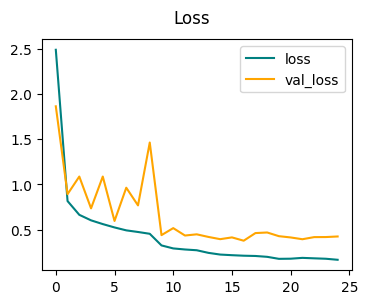

In [28]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

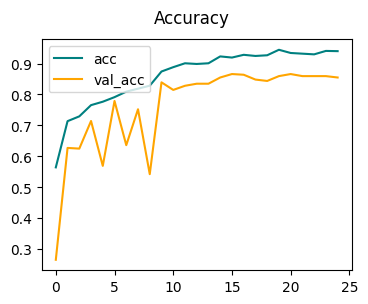

In [29]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

### Evaluate Last Case of Model

In [30]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [31]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)

1/1 [==============================] - 0s 87ms/step


In [32]:
def print_scores(f1, pre, rec, c_acc):
    f1_score = f1.result().numpy() * 100
    pre_score = pre.result().numpy() * 100
    rec_score = rec.result().numpy() * 100
    c_acc_score = c_acc.result().numpy() * 100
    print(f"Precision: {pre_score:.2f}")
    print(f"Recall: {rec_score:.2f}")
    print(f"Categorical Accuracy: {c_acc_score:.2f}")
    print("F1 Score: ", f1_score)

In [33]:
print_scores(f1, pre, rec, c_acc)

Precision: 87.37
Recall: 86.50
Categorical Accuracy: 87.17
F1 Score:  [77.894745 91.15646  94.55782  85.01529 ]


## More Visualization (Tensorboard)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

In [ ]:
test_log = 'logs/test'
img_dir = "D:\\DATASETS\\Car-Plant-House-Road-Dataset\\Sample-Thesis-Dataset\\2.png"

file_writer = tf.summary.create_file_writer(test_log)
img = image_to_numpy.load_image_file(os.path.join(img_dir))
img = cv2.resize(img, (256, 256))
img = np.reshape(img, (-1, 256, 256, 3))

In [ ]:
# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", img, step=0)

In [ ]:
# AppData/Local/Temp/.tensorboard-info - delete folder if it cannot load
%tensorboard --logdir=logs/

## Load Best Model from Checkpoint and Evaluate

In [34]:
saved_model = tf.keras.models.load_model("checkpoints\\Model_V4-0-5_FIXED20240302-181105")

In [35]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)     

In [36]:
best_result = saved_model.evaluate(test_set, return_dict=True, verbose=2)
print(best_result)

75/75 - 3s - loss: 0.3188 - accuracy: 0.8800 - 3s/epoch - 46ms/step
{'loss': 0.31875061988830566, 'accuracy': 0.8799999952316284}


In [55]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [56]:
test_images = []
test_labels = []
test_preds = [] 

In [57]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = saved_model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)
    
    for i in range(len(y)):
        test_images.append(X[i])
        test_labels.append(y[i])
        test_preds.append(yhat[i])

1/1 [==============================] - 0s 79ms/step


In [58]:
print_scores(f1, pre, rec, c_acc)

Precision: 89.08
Recall: 87.00
Categorical Accuracy: 88.50
F1 Score:  [79.40076 92.87926 96.57321 83.04498]


## Visualize Misclassified Images

In [59]:
test_images_c = np.array(test_images)

test_labels_c = [np.argmax(x) for x in test_labels]
test_labels_c = np.array(test_labels_c)

test_preds_c = [np.argmax(x) for x in test_preds]
test_preds_c = np.array(test_preds_c)

In [60]:
test_labels_c[:10]

array([1, 0, 0, 3, 1, 3, 3, 3, 3, 1], dtype=int64)

In [61]:
test_labels[:10]

[array([0., 1., 0., 0.], dtype=float32),
 array([1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 1., 0., 0.], dtype=float32)]

###  Plotting Confusion Matrix 

In [62]:
cm = sklearn.metrics.confusion_matrix(test_labels_c, test_preds_c)

Text(0.5, 1.0, 'Confusion Matrix')

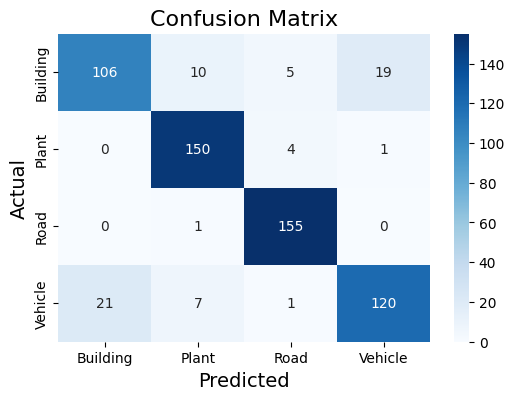

In [63]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=True,
            xticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            yticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

### Visualize Misclassified Images

In [64]:
misclassified = test_labels_c - test_preds_c

In [65]:
mis_idx = np.where(misclassified != 0)

In [66]:
m = np.squeeze(mis_idx)

In [67]:
def toClasses(x):
    if x == 0:
        return 'Building'
    if x == 1:
        return 'Plant'
    if x == 2:
        return 'Road'
    if x == 3:
        return 'Vehicle'

In [68]:
toClasses_vectorized = np.vectorize(toClasses)

In [69]:
test_label_names = toClasses_vectorized(test_labels_c)
test_pred_names = toClasses_vectorized(test_preds_c)

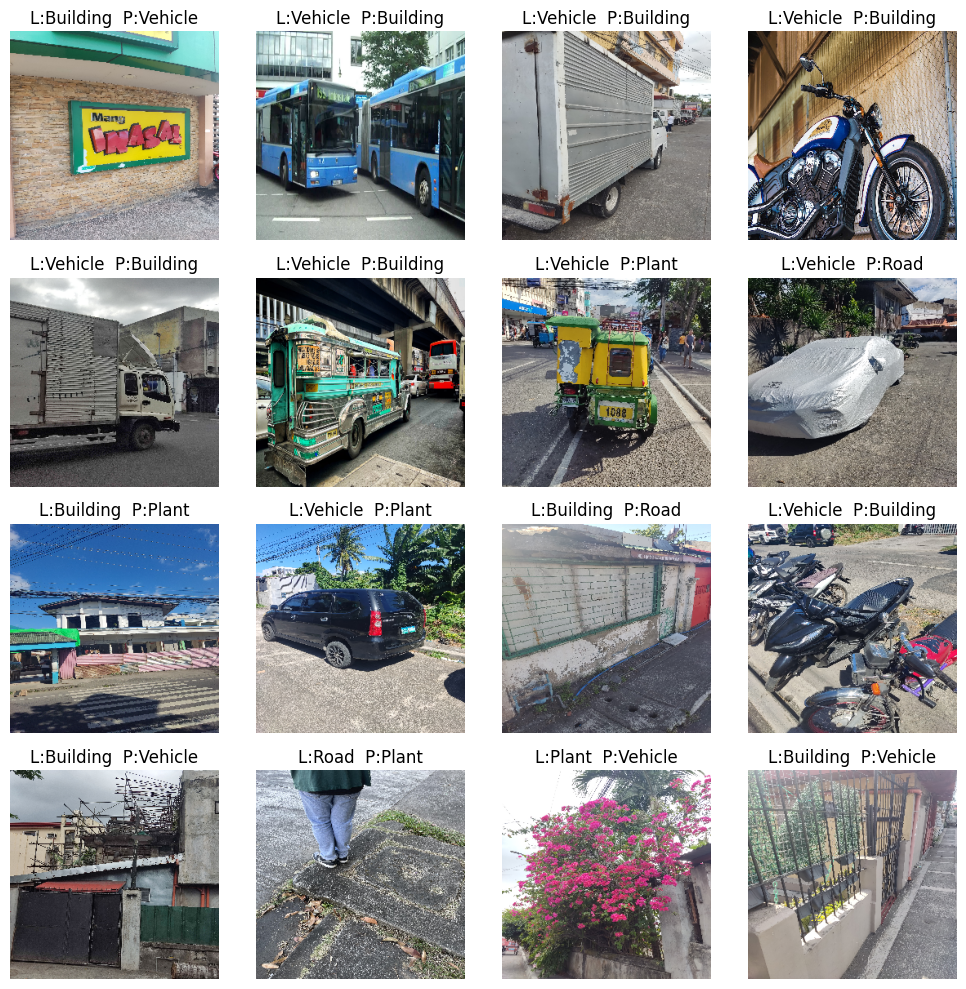

In [70]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for idx, ax_idx in enumerate(itertools.product(range(4), range(4))):
    ax[ax_idx].imshow(test_images_c[m[idx]].astype(float))
    ax[ax_idx].title.set_text(f'L:{test_label_names[m[idx]]}  P:{test_pred_names[m[idx]]}' )
    ax[ax_idx].axis('off')
fig.tight_layout()

## Save Model For API

In [53]:
# saved_model = tf.keras.models.load_model('checkpoints\\Model_V4-0-0')

In [54]:
saved_model.save("models/Model_V4-0-5_FIXED20240302-181105.keras")

## See what the model sees

In [ ]:
saved_model.summary()

In [ ]:
len(saved_model.layers)

In [ ]:
layers_c1 = saved_model.layers[:6]
model_c1 = Sequential(layers_c1)
model_c1.summary()

In [ ]:
img_sample_dir = "D:\\DATASETS\\For-Thesis\\From Other Datasets\\Stanford-Car-Dataset\\cars_train\\cars_train\\00006.jpg"

In [ ]:
model_c1.input_shape

In [ ]:
image_size = 256
img_sample = image_to_numpy.load_image_file(os.path.join(img_sample_dir))
img_sample = cv2.resize(img_sample, (image_size, image_size))
img_sample = img_sample.astype(np.float32) / 255.0

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img_sample.astype(float))

In [ ]:
output_c1 = model_c1.predict(np.expand_dims(img_sample, 0))

In [ ]:
output_c1[0,:,:,0].shape

In [ ]:
def viz_grid(output, ncols=4, nrows=4):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    # itertools.product creates a permutation 
    for idx, ax_idx in enumerate(list(itertools.product(range(ncols), range(nrows)))):
        ax[ax_idx[1], ax_idx[0]].imshow(output[0,:,:,idx])

In [ ]:
viz_grid(output_c1, 4, 4)

In [ ]:
layers_c2 = saved_model.layers[:10]
model_c2 = Sequential(layers_c2)
model_c2.summary()

In [ ]:
output_c2 = model_c2.predict(np.expand_dims(img_sample, 0))

In [ ]:
viz_grid(output_c2, 4, 4)

In [ ]:
layers_c3 = saved_model.layers[:14]
model_c3 = Sequential(layers_c3)
model_c3.summary()

In [ ]:
output_c3 = model_c3.predict(np.expand_dims(img_sample, 0))
output_c3.shape

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(15,15))
# itertools.product creates a permutation 
for idx, ax_idx in enumerate(list(itertools.product(range(4), range(8)))):
    ax[ax_idx[1], ax_idx[0]].imshow(output_c3[0,:,:,idx])
    
fig.tight_layout()

In [ ]:
yhat = saved_model.predict(np.expand_dims(img_sample, 0))

In [ ]:
# 0 is building
np.argmax(yhat)